In [1]:
import sys
sys.path.append('../')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.policy_gradient import PolicyGradient, TRPO, PPO
from mrl.environment import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
os.environ['ncpus'] = '0'

In [3]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [4]:
# ds = Vec_Recon_Dataset(['CCC'], vocab, partial(failsafe_fp, fp_function=ECFP6))
ds = Vec2Text_Dataset([('CCC', '')], vocab, partial(failsafe_fp, fp_function=ECFP6))

encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
lstm_drop = 0.0
lin_drop = 0.0
bidir = False
condition_hidden = True
condition_output = False
bos_idx = vocab.stoi['bos']

lm_model = Conditional_LSTM_LM(encoder, d_vocab, d_embedding, d_hidden, d_latent, n_layers,
                lstm_drop, lin_drop, bidir, condition_hidden, condition_output, bos_idx)

lm_model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

loss = CrossEntropy()

In [5]:
vh = ValueHead(256)
# vh = None

In [6]:
agent = GenerativeAgent(lm_model, vocab, loss, ds, value_head=vh, opt_kwargs={'lr':1e-4},
                       base_update=0.9, v_update=0.9, vopt_kwargs={'lr':1e-3})

In [7]:
def scale_sa(sa):
    return (10-sa)/9

In [8]:
# template = Template([ValidityFilter(), SingleCompoundFilter()],
#                     [QEDFilter(0.5, None, score=1.),
#                      SAFilter(None, 3, score=1.)], 
#                     fail_score=-1.)

template = Template([ValidityFilter(), SingleCompoundFilter()],
                    [QEDFilter(None, None, score=PassThroughScore()),
                     SAFilter(None, None, 
                              score=PropertyFunctionScore(scale_sa))], fail_score=-1., 
                            log=False, use_lookup=False, cpus=0)

In [9]:
gen_bs = 1000
bs = 256

In [10]:
agent_cb = GenAgentCallback(agent, 'generative', contrastive=True)

In [11]:
df = next(pd.read_csv('/home/dmai/smiles_datasets/shard_0.csv', chunksize=2000000, usecols=['smiles']))

In [12]:
df = df[df.smiles.map(lambda x: 8<len(x)<100)]

In [13]:
df.shape

(1999873, 1)

In [14]:
# sampler1 = ModelSampler(agent, agent.model, 'live', 400, 0., gen_bs, latent=False, track=True)

sampler1 = DatasetSampler(df.smiles.values, 2000, 'zinc')

# zinc_model = Conditional_LSTM_LM(encoder, d_vocab, d_embedding, d_hidden, d_latent, n_layers,
#                 lstm_drop, lin_drop, bidir, condition_hidden, condition_output, bos_idx)

# zinc_model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))
# to_device(zinc_model);

# sampler2 = ModelSampler(agent, zinc_model, 'base', 400, 0., gen_bs)

# samplers = [sampler1, sampler2]

samplers = [sampler1]

In [15]:
samplers = [ContrastiveSampler(i, agent, agent.model, 3000, repeats=4) for i in samplers]

In [16]:
# pg = PolicyGradient(ratio=False)
# pg = TRPO(0.97, 4.)
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss1 = LossCallback(pg, 'pg')

In [17]:
class FPSimilarity():
    def __init__(self, fp_function, distance_function, min_sim, max_sim, 
                 passscore, failscore, soft_min=None, soft_max=None):
        self.fp_function = fp_function
        self.distance_function = distance_function
        self.min_sim = min_sim
        self.max_sim = max_sim
        self.passscore = passscore
        self.failscore = failscore
        self.soft_min = soft_min
        self.soft_max = soft_max
        
    def get_sims(self, source_smiles, target_smiles):
        source_fps = [failsafe_fp(i, self.fp_function) for i in source_smiles]
        target_fps = [failsafe_fp(i, self.fp_function) for i in target_smiles]
        
        sims = np.array([self.distance_function(source_fps[i], [target_fps[i]])[0] 
                 for i in range(len(source_smiles))])
        return sims
        
    def score(self, source_smiles, target_smiles, sims=None):
        if sims is None:
            sims = self.get_sims(source_smiles, target_smiles)
            
        min_sim = self.min_sim if self.soft_min is None else self.soft_min
        max_sim = self.max_sim if self.soft_max is None else self.soft_max
        bools = (min_sim<sims) & (sims<max_sim)
            
        return bools*self.passscore + (~bools)*self.failscore
            
    def bools(self, source_smiles, target_smiles, sims=None):
        if sims is None:
            sims = self.get_sims(source_smiles, target_smiles)
        
        bools = (self.min_sim<sims) & (sims<self.max_sim)
        return bools
        


In [18]:
sf = FPSimilarity(ECFP6, tanimoto_rd, 0.2, 0.95, 0.05, -1., soft_min=0.4, soft_max=0.9)

In [19]:
template_cb = ContrastiveTemplate(sf, max_score=2., template=template, prefilter=True)

In [20]:
base_cb = UpdateBaselineCB(agent, 8, 'base_update')

In [21]:
env = Environment(agent_cb, template_cb, samplers=samplers, reward_cbs=[], 
                  loss_cbs=[loss1], cbs=[base_cb])

In [22]:
df2 = pd.read_csv('contrastive.csv')

In [23]:
df2['rewards'] = df2.apply(lambda row: (row['target_template']-row['source_template'])/(2-row['source_template']), axis=1)

In [24]:
df2['rewards'] = df2.rewards + df2.sim.map(lambda x: 0.05 if ((x>0.3) and (x<0.9)) else -0.1)

In [25]:
df2['samples'] = df2.apply(lambda row: (row['sources'], row['targets']), axis=1)

In [28]:
df2[(df2.rewards>0.5) & (df2.sim.between(0.3, 0.9))]

,sources,targets,source_template,target_template,template_diff,sim,rewards,samples
61,O=C(Nc1c(F)cccc1Oc1ccccc1)c1ccc(OCc2ccccn2)cc1,O=C(Nc1c(F)cccc1F)c1ccc(OCc2ccccn2)cc1,1.299078,1.663756,0.364679,0.671053,0.570284,(O=C(Nc1c(F)cccc1Oc1ccccc1)c1ccc(OCc2ccccn2)cc...
196,O=C(CNC(=O)OCC1c2ccccc2-c2ccccc21)OCC(=O)N1CCOCC1,O=C(NCC(=O)N1CCOCC1)OCC1c2ccccc2-c2ccccc21,1.565747,1.769703,0.203956,0.750000,0.519671,(O=C(CNC(=O)OCC1c2ccccc2-c2ccccc21)OCC(=O)N1CC...
316,CC(C)Oc1nnc(S[C@@H](C)C(=O)NC(=O)Nc2ccccc2)s1,CC(C)Oc1nnc(NC(=O)Nc2ccccc2)s1,1.562559,1.773412,0.210853,0.493151,0.532015,(CC(C)Oc1nnc(S[C@@H](C)C(=O)NC(=O)Nc2ccccc2)s1...
953,COC[C@@H]1CCCCN1C(=O)c1cc(C(=O)O)nc2c1-c1[nH]c...,COC[C@@H]1CCCCN1C(=O)c1cc(=O)[nH]c2nc(C(=O)O)c...,1.302851,1.640916,0.338065,0.443396,0.534925,(COC[C@@H]1CCCCN1C(=O)c1cc(C(=O)O)nc2c1-c1[nH]...
1064,CCOC(=O)c1cc(C)c(NC(=N)C(C)(C)C)cc1C,CCOC(=O)c1cc(NC(C)(C)C(C)(C)C)c(C)cc1C,1.333026,1.649440,0.316413,0.428571,0.524402,"(CCOC(=O)c1cc(C)c(NC(=N)C(C)(C)C)cc1C, CCOC(=O..."
...,...,...,...,...,...,...,...,...
552863,O=Cc1ccc(OCC(=O)N2CCN(C(=O)c3cccnc3)CC2)c([N+]...,Cc1ccc(OCC(=O)N2CCN(C(=O)c3ccc(C)cc3)CC2)cc1,1.265461,1.770270,0.504809,0.311828,0.737246,(O=Cc1ccc(OCC(=O)N2CCN(C(=O)c3cccnc3)CC2)c([N+...
552864,Cc1ccc([C@H](C)NCc2ccc(OCC(=O)O)c([N+](=O)[O-]...,Cc1ccc(CN[C@H](C)c2ccc(C)cc2)cc1,1.401130,1.739435,0.338305,0.426471,0.614906,(Cc1ccc([C@H](C)NCc2ccc(OCC(=O)O)c([N+](=O)[O-...
552865,CCOCc1nnc(N2C[C@@H](F)[C@@H](c3ccccc3)C2)n1CC1...,CCOCc1nnc(N2CCCC2)n1Cc1ccccc1,1.250035,1.690846,0.440810,0.371134,0.637775,(CCOCc1nnc(N2C[C@@H](F)[C@@H](c3ccccc3)C2)n1CC...
552866,CCOC(=O)C(NC(=S)Nc1ccccc1OC(F)(F)F)C(=O)OCC,CCOc1ccccc1NC(=O)c1ccccc1,1.250881,1.855585,0.604704,0.320000,0.857221,"(CCOC(=O)C(NC(=S)Nc1ccccc1OC(F)(F)F)C(=O)OCC, ..."


In [29]:
# agent.update_dataset_from_inputs(df2[df2.rewards>0.4].samples.values)
agent.update_dataset_from_inputs(df2[(df2.rewards>0.5) & (df2.sim.between(0.3, 0.9))].samples.values)

In [30]:
agent.train_supervised(256, 1, 5e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.13586,0.12640,03:28


In [31]:
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

In [21]:
%%time
env.fit(bs, 90, 10, 5)

iterations,rewards,valid,diversity,template,template_temp,template_sim,pg
0,0.039,1.000,1.000,0.039,-0.011,0.050,-0.019
5,0.042,1.000,1.000,0.042,-0.008,0.050,-0.002


CPU times: user 38 s, sys: 8.62 s, total: 46.6 s
Wall time: 1min 10s


In [32]:
%%time
env.fit(bs, 90, 100, 5)

iterations,rewards,template,template_temp,template_sim,diversity,valid,bs,pg
0,-0.366,-0.366,0.297,-0.664,1.000,1.000,256,0.321
5,-0.254,-0.254,0.328,-0.582,1.000,1.000,256,0.230
10,-0.316,-0.316,0.266,-0.582,1.000,1.000,256,0.231
15,-0.367,-0.367,0.268,-0.635,1.000,1.000,256,0.238
20,-0.341,-0.341,0.278,-0.619,1.000,1.000,256,0.133
25,-0.289,-0.289,0.272,-0.561,1.000,1.000,256,0.222
30,-0.324,-0.324,0.282,-0.606,1.000,1.000,256,0.121
35,-0.335,-0.335,0.279,-0.614,1.000,1.000,256,0.236
40,-0.260,-0.260,0.280,-0.541,1.000,1.000,256,0.123
45,-0.303,-0.303,0.283,-0.586,1.000,1.000,256,0.158


CPU times: user 4min 51s, sys: 191 ms, total: 4min 51s
Wall time: 4min 51s


In [37]:
%%time
env.fit(bs, 90, 300, 5)

iterations,rewards,template,template_temp,template_sim,diversity,valid,bs,pg
100,-0.218,-0.218,0.294,-0.512,1.000,1.000,256,0.137
105,-0.273,-0.273,0.288,-0.561,1.000,1.000,256,0.164
110,-0.217,-0.217,0.295,-0.512,1.000,1.000,256,0.401
115,-0.221,-0.221,0.270,-0.491,1.000,1.000,256,0.111
120,-0.208,-0.208,0.288,-0.496,1.000,1.000,256,0.188
125,-0.240,-0.240,0.280,-0.520,1.000,1.000,256,0.560
130,-0.250,-0.250,0.286,-0.537,1.000,1.000,256,0.195
135,-0.233,-0.233,0.316,-0.549,1.000,1.000,256,0.122
140,-0.219,-0.219,0.310,-0.528,1.000,1.000,256,0.224
145,-0.269,-0.269,0.300,-0.569,1.000,1.000,256,0.119


CPU times: user 14min 37s, sys: 688 ms, total: 14min 38s
Wall time: 14min 37s


In [40]:
%%time
env.fit(bs, 90, 400, 5)

iterations,rewards,template,template_temp,template_sim,diversity,valid,bs,pg
400,-0.245,-0.245,0.308,-0.553,1.000,1.000,256,0.177
405,-0.166,-0.166,0.338,-0.504,1.000,1.000,256,0.360
410,-0.230,-0.230,0.331,-0.561,1.000,1.000,256,0.186
415,-0.270,-0.270,0.328,-0.598,1.000,1.000,256,0.191
420,-0.200,-0.200,0.308,-0.508,1.000,1.000,256,0.200
425,-0.247,-0.247,0.326,-0.573,1.000,1.000,256,0.118
430,-0.281,-0.281,0.330,-0.610,1.000,1.000,256,0.200
435,-0.231,-0.231,0.326,-0.557,1.000,1.000,256,0.264
440,-0.199,-0.199,0.317,-0.516,1.000,1.000,256,0.194
445,-0.225,-0.225,0.324,-0.549,1.000,1.000,256,1.507


CPU times: user 20min 40s, sys: 860 ms, total: 20min 40s
Wall time: 20min 39s


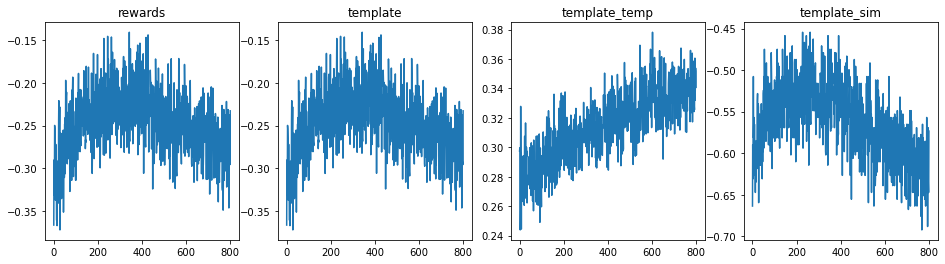

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(16,4))
plot_vals = ['rewards', 'template', 'template_temp', 'template_sim']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.metrics[plot_vals[i]]))
    ax.set_title(plot_vals[i])

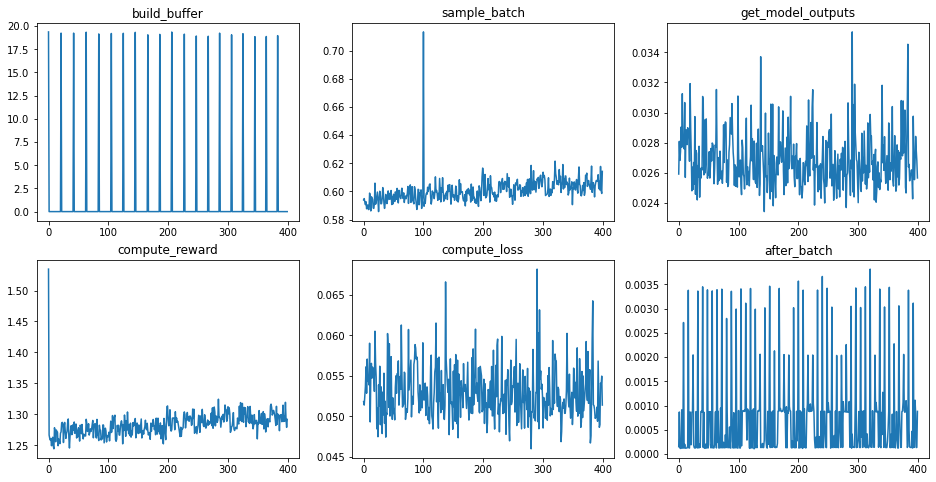

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))
plot_vals = ['build_buffer', 'sample_batch', 'get_model_outputs', 
             'compute_reward', 'compute_loss', 'after_batch']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.timelog[plot_vals[i]]))
    ax.set_title(plot_vals[i])

In [35]:
df3 = log_to_df(env.log.log, ['samples', 'rewards', 'template', 'template_temp',
       'template_sim'] )

In [36]:
df3

,batch,samples,rewards,template,template_temp,template_sim
0,0,"(CCCN(C(=O)CCN(C)CC)[C@@H]1CCN(Cc2ncc(C)o2)C1,...",0.160937,0.160937,0.110937,0.05
1,0,(C[C@@H](C(=O)NC1CC1)N1CCN(C(=S)Nc2cccc(Br)c2)...,-0.093381,-0.093381,-0.143381,0.05
2,0,(CCN(C)C(=O)c1cccc(NC(=O)C(=O)NCc2nc(C3CC3)no2...,0.152756,0.152756,0.102756,0.05
3,0,(COC(=O)N1CCC(Cn2c(COc3ccc(OC)cc3)nnc2N2C[C@H]...,0.388702,0.388702,0.338702,0.05
4,0,(Cc1ncncc1C(=O)N[C@@H]1CN(C(=O)[C@H]2CC2(F)F)C...,0.299853,0.299853,0.249853,0.05
...,...,...,...,...,...,...
238420,990,(O=C(Nc1ccc(OCc2ccccc2F)cc1)[C@@H]1CCS(=O)(=O)...,0.274791,0.274791,0.224791,0.05
238421,990,(Cc1ccc([C@H](C)NCc2ccc(OCC(=O)O)c([N+](=O)[O-...,0.388305,0.388305,0.338305,0.05
238422,990,(CCOCc1nnc(N2C[C@@H](F)[C@@H](c3ccccc3)C2)n1CC...,0.490810,0.490810,0.440810,0.05
238423,990,"(CCOC(=O)C(NC(=S)Nc1ccccc1OC(F)(F)F)C(=O)OCC, ...",0.654704,0.654704,0.604704,0.05


In [39]:
df3.drop_duplicates(subset='samples', inplace=True)

In [40]:
df4 = pd.concat([df2, df3])

In [42]:
df4.drop_duplicates(subset='samples', inplace=True)

In [43]:
df4.shape

(552868, 6)

In [44]:
df4.to_csv('contrastive_data.csv', index=False)

In [46]:
samples = df.sample(n=10000).smiles.values

In [47]:
pairs = [(i,'') for i in samples]

In [92]:
ds = agent.dataset.new(pairs)

In [93]:
dl = ds.dataloader(128, shuffle=False)

In [94]:
len(dl)

79

In [95]:
outputs = []
for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,_ = batch
    z = agent.model.x_to_latent(x)
    z = z.unsqueeze(1).repeat(1,8,1).view(-1,512)
    preds, _ = agent.model.sample_no_grad(z.shape[0], 100, z=z)
    new_sequences = agent.reconstruct(preds)
    outputs.append(new_sequences)

In [96]:
outputs = flatten_list_of_lists(outputs)

In [97]:
len(outputs)

80000

In [98]:
%%time
template.cpus=64
output_scores = template.eval_mols(outputs)
template.cpus=3

CPU times: user 726 ms, sys: 4.45 s, total: 5.18 s
Wall time: 9.63 s


In [99]:
output_scores[:10]

[1.8136276591513028,
 1.7748604670141332,
 1.6993642174060333,
 1.7209743056349702,
 1.767877641551118,
 1.8204415692960396,
 1.812616927219032,
 1.812616927219032,
 1.831758982401984,
 1.831758982401984]

In [100]:
outputs = chunk_list(outputs, 8)
output_scores = chunk_list(output_scores, 8)

In [101]:
%%time
template.cpus=32
base_scores = template.eval_mols(samples)
template.cpus=3

CPU times: user 117 ms, sys: 2.46 s, total: 2.57 s
Wall time: 4.17 s


In [102]:
np.array(output_scores).max(-1)

array([1.82044157, 1.83175898, 1.77916687, ..., 1.7474935 , 1.87203225,
       1.86304831])

(0.75, 2.0)

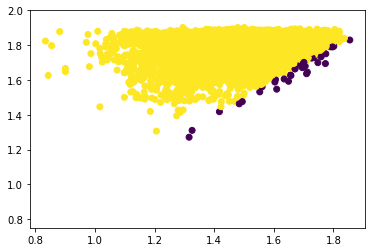

In [105]:
plt.scatter(base_scores, np.array(output_scores).max(-1), c=np.array(output_scores).max(-1)>np.array(base_scores))
plt.ylim(0.75,2)

(-1.0, 2.0)

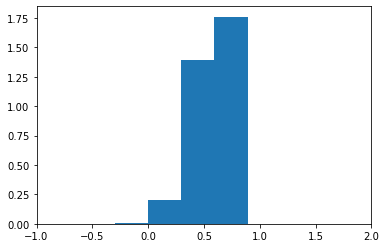

In [106]:
plt.hist((np.array(output_scores).max(-1) - np.array(base_scores))/(2-np.array(base_scores)), density=True, bins=20)
plt.xlim(-1,2)

In [107]:
rel_score = (np.array(output_scores).max(-1) - np.array(base_scores))/(2-np.array(base_scores))

In [108]:
(rel_score>0.85).sum()

14

In [109]:
sims = sf.get_sims(samples, [i[0] for i in outputs])

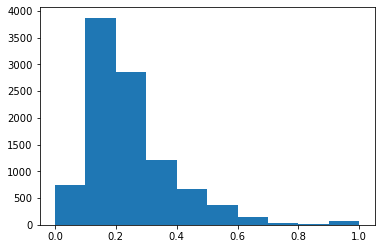

In [110]:
plt.hist(sims);

In [111]:
(np.array(sims)>0.3).mean()

0.2528

In [79]:
idxs = np.arange(len(rel_score))[(rel_score>0.85)]

In [80]:
sources = [samples[i] for i in idxs]
targets = [outputs[i] for i in idxs]

In [83]:
t_scores = [output_scores[i] for i in idxs]

In [81]:
sources

['COc1cc([N+](=O)[O-])c(C(=O)OC[C@H]2CCCN(C(=O)OC(C)(C)C)C2)cc1SC',
 'CS(=O)(=O)NC[C@H]1CCCN(CN2C(=O)C(=O)N(C34CC5CC(CC(C5)C3)C4)C2=O)C1',
 'COc1nc(C(=O)NC[C@H](O)CNCc2cc(-c3nn[nH]n3)ccc2F)co1',
 'COc1ccc(C(=O)NCCC[C@H](C)CO)cc1S(=O)(=O)N[C@H]1CCCC[C@@H]1C',
 'COc1cc([N+](=O)[O-])c(C(=O)OCc2cnn(-c3ccccc3)c2)cc1SC',
 'ON[C@H]1CCNC1',
 'O=C(CCO)CNc1cc([N+](=O)[O-])cc[n+]1[O-]',
 'COc1cc(CCc2cc(OC)c(OC(=O)[C@H](O)COP(=O)(O)O)c(OC)c2)ccc1O',
 'CC(C)(C)NS(=O)(=O)c1ccc(NC(=O)N[C@H]2CCCC[C@@H]2NS(C)(=O)=O)nc1']

In [85]:
np.array(t_scores[0]).argmax()

1

In [86]:
targets = [targets[i][np.array(t_scores[i]).argmax()] for i in range(len(targets))]

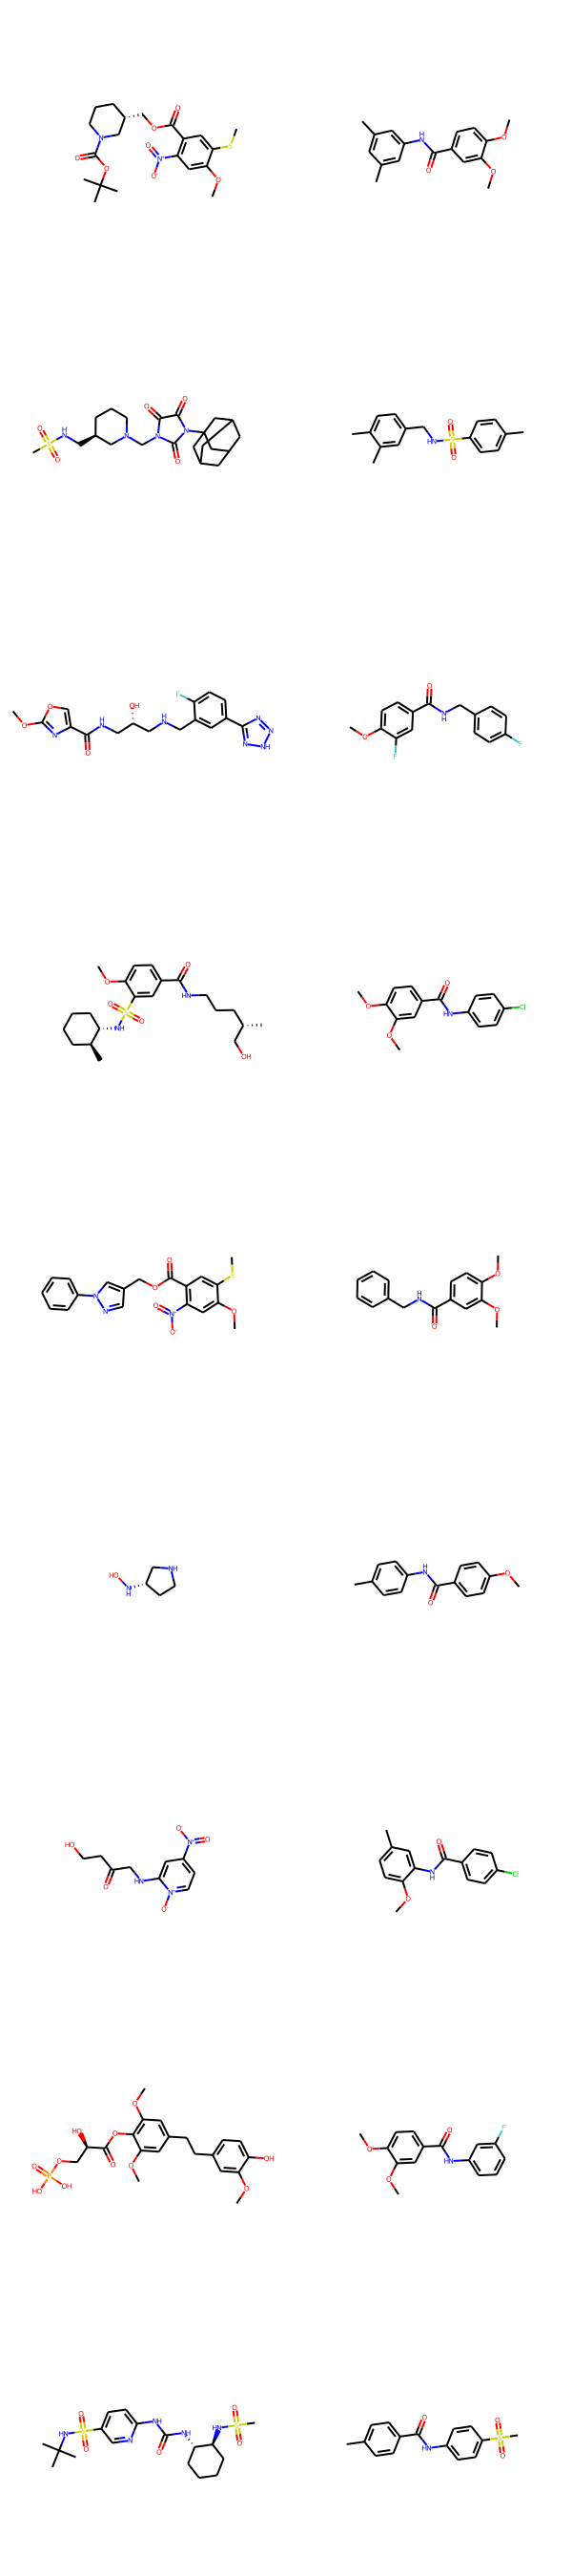

In [87]:
draw_mols(to_mols(flatten_list_of_lists(zip(sources,targets))), mols_per_row=2)

In [77]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

<All keys matched successfully>

In [79]:
np.percentile(log_df.rewards.values, 75)

0.3068362772464752

In [81]:
agent.update_dataset_from_inputs(log_df[log_df.rewards>np.percentile(log_df.rewards.values, 75)].samples.values)

In [82]:
agent.train_supervised(64, 1, 1e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.18819,0.23523,02:09


In [136]:
agent.update_dataset_from_inputs(log_df[log_df.rewards>np.percentile(log_df.rewards.values, 85)].samples.values)
agent.train_supervised(64, 1, 1e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.20413,0.29077,01:17


big question
    should the buffer for contrastive traaining hold tuples
    pros - allows for hand designed pairs
    cons - complexity
    could happen in agent after sample?

In [100]:
smile = 'CCC(=O)Nc1ccc(NC(=O)NCCc2cccs2)cc1C'
new_ds = ds.new([smile])
batch = to_device(new_ds.collate_function([new_ds[i] for i in range(len(new_ds))]))

In [101]:
x,y = batch

In [102]:
x

[tensor([[ 0, 23, 23, 23,  5, 20, 28,  6, 27, 34, 11, 34, 34, 34,  5, 27, 23,  5,
          20, 28,  6, 27, 23, 23, 34, 12, 34, 34, 34, 40, 12,  6, 34, 34, 11, 23,
           1]], device='cuda:0'),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')]

In [103]:
agent.model.eval();

In [104]:
z = agent.model.x_to_latent(x)
preds, _ = agent.model.sample_no_grad(200, env.sl, z=z.repeat(200,1), temperature=1.)
new_sequences = agent.reconstruct(preds)

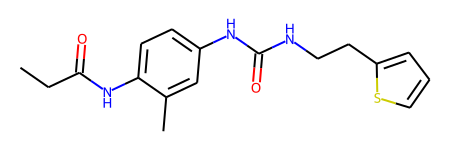

In [105]:
to_mol(smile)

In [106]:
m = [i for i in to_mols(new_sequences) if i is not None]

In [107]:
agent.model.train();

In [108]:
len(new_sequences), len(set(new_sequences))

(200, 9)

In [109]:
qed(to_mol(smile))

0.7538950146959063

In [110]:
[qed(i)-qed(to_mol(smile)) for i in to_mols(list(set(new_sequences)))]

[0.039273560067691005,
 0.1038682273213214,
 0.03439136272964527,
 0.15344011465687724,
 0.003647020980417248,
 0.0,
 0.009449008441467677,
 0.032293207593628304,
 0.03439136272964527]

In [111]:
[sa_score(i)-sa_score(to_mol(smile)) for i in to_mols(list(set(new_sequences)))]

[-0.07500355029585748,
 -0.19386410540412946,
 -0.2970106508875716,
 -0.09397290315075324,
 -0.24150254851740627,
 0.005634319526627962,
 -0.11025834309054083,
 -0.034024489847009676,
 -0.29594556213017853]

In [112]:
np.array(template(list(set(new_sequences)), filter_type='soft')) - template(smile, filter_type='soft')

array([ 0.04760729,  0.12540868,  0.06739255,  0.16388155,  0.03048064,
       -0.00062604,  0.02169994,  0.03607371,  0.0672742 ])

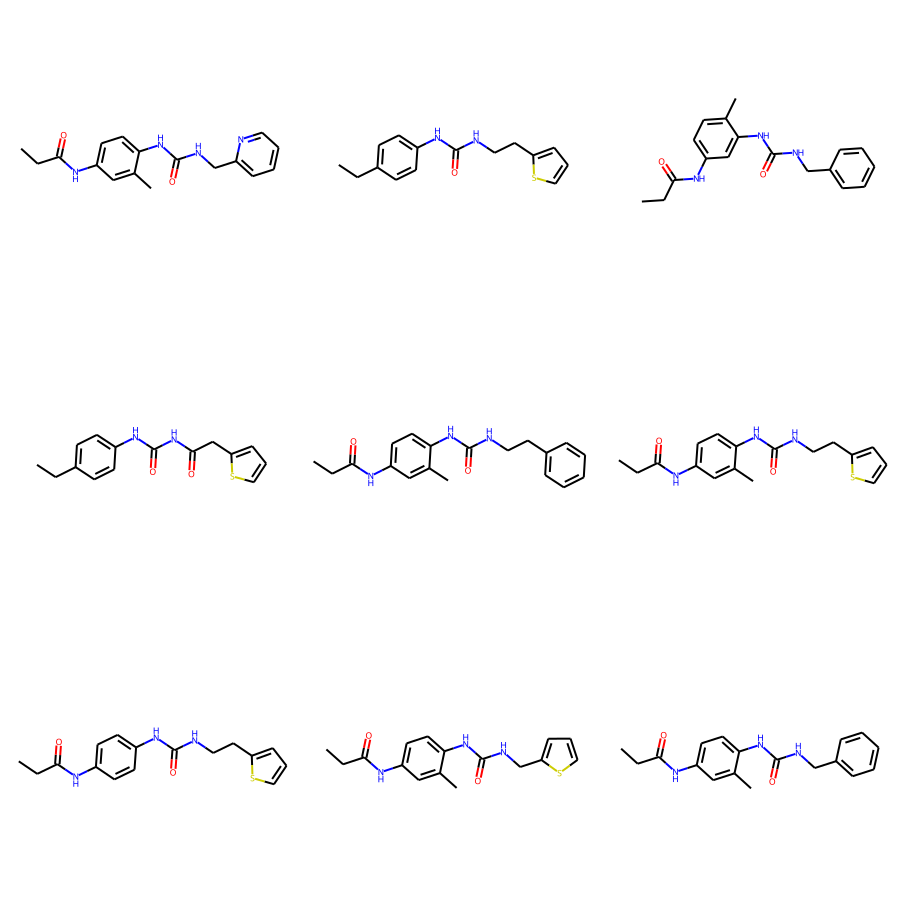

In [113]:
draw_mols(to_mols(list(set(new_sequences))))

In [ ]:
results = []

for b, batch in enumerate(smiles_batches):
    if b%10==0:
        print(b)
    data = flatten_list_of_lists([[i]*8 for i in batch])
    pred_ds = ds.new(data)
    batch = pred_ds.collate_function([pred_ds[i] for i in range(len(pred_ds))])
    x,y = batch
    x, cond = x
    with torch.no_grad():
        z = agent.model.to_latent(cond)
        preds, _ = agent.model.sample_no_grad(z.shape[0], 90, z=z, multinomial=True)
        outsmiles = agent.reconstruct(preds)
    
    results.append([data, outsmiles])